In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import operator
import seaborn as sns
import statsmodels
import statsmodels.tsa.seasonal 

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
start = dt.datetime(2020, 1, 1)

In [3]:
index = web.DataReader('TM', "yahoo", start).index

In [4]:
high = pd.DataFrame(index=index)
low = pd.DataFrame(index=index)
openn = pd.DataFrame(index=index)
close = pd.DataFrame(index=index)
volume = pd.DataFrame(index=index)
adj_close = pd.DataFrame(index=index)

### Japan

In [5]:
'''stocks_japan = ['TM', '8058.T', 'HMC', '1JP.F', 'NPEXY', 'ITOCY', 'NSANY', 'SFTBY', 'HTHIY', 'JXHLY',
                'SNE','AONNY', 'PCRFY', 'MARUY', 'DCNSF', 'MITSY', 'SVNDY', 'TYHOF', 'MUFG', 'TOELY', \
                'NISTF', 'SMFG', 'MSADY', 'TKOMY', 'DNZOY', 'SOMMY', 'KDDIY', 'MIELY', 'DWAHY', 'MHVYF', \
                'ASEKY', 'CAJ', 'FJTSY', 'MFG', 'MTLHY', 'IDKOY', 'JFEEF', 'SZKMY', 'TOSBF', 'BRDCY', \
                'NHOLF', 'SSUMY', 'MZDAY', 'KAEPY', 'MAHLY', 'SMTOF', 'FUJHY', 'CHUEF', 'EJPRY', 'NEC1.F']    
df = {}

# fill datasets
for ticker in stocks_japan:
    d_ticker = web.DataReader(ticker, "yahoo", start)
    
    if ticker == '8058.T':
        ticker = 'Mitsubishi'
    
    high[ticker] = d_ticker.High
    low[ticker] = d_ticker.Low
    openn[ticker] = d_ticker.Open
    close[ticker] = d_ticker.Close
    adj_close[ticker] = d_ticker['Adj Close']

# save data:
high.to_csv('datasets_stocks/japan_high.csv')
low.to_csv('datasets_stocks/japan_low.csv')
openn.to_csv('datasets_stocks/japan_open.csv')
close.to_csv('datasets_stocks/japan_close.csv')
adj_close.to_csv('datasets_stocks/japan_adj_close.csv')'''

high = pd.read_csv('datasets_stocks/japan_high.csv')
low = pd.read_csv('datasets_stocks/japan_low.csv')
openn = pd.read_csv('datasets_stocks/japan_open.csv')
close = pd.read_csv('datasets_stocks/japan_close.csv')
adj_close = pd.read_csv('datasets_stocks/japan_adj_close.csv')

The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance. 

In [6]:
# create dictionary of datasets
datasets = {'high':high, 'low':low, 'open':openn, 'close':close, 'adj_close':adj_close}

In [7]:
columns = high.columns
columns

Index(['Date', 'TM', 'Mitsubishi', 'HMC', '1JP.F', 'NPEXY', 'ITOCY', 'NSANY',
       'SFTBY', 'HTHIY', 'JXHLY', 'SNE', 'AONNY', 'PCRFY', 'MARUY', 'DCNSF',
       'MITSY', 'SVNDY', 'TYHOF', 'MUFG', 'TOELY', 'NISTF', 'SMFG', 'MSADY',
       'TKOMY', 'DNZOY', 'SOMMY', 'KDDIY', 'MIELY', 'DWAHY', 'MHVYF', 'ASEKY',
       'CAJ', 'FJTSY', 'MFG', 'MTLHY', 'IDKOY', 'JFEEF', 'SZKMY', 'TOSBF',
       'BRDCY', 'NHOLF', 'SSUMY', 'MZDAY', 'KAEPY', 'MAHLY', 'SMTOF', 'FUJHY',
       'CHUEF', 'EJPRY', 'NEC1.F'],
      dtype='object')

### Fill NaNs

In [8]:
def fill_nan (dataset, index):
    
    # count nans:
    num_nans = dataset.isna().values.sum()
    print(f"Totally, in the dataset there are {num_nans} NaNs values")
    if num_nans>0:
        if 'Date' in dataset.columns:
            dataset = dataset.drop('Date', axis=1) # drop date because the next line works only with floats
        dataset = (dataset.ffill() + dataset.bfill())/2
        dataset['Date'] = index # reintegrate the index
    
        num_nans = dataset.isna().values.sum()
        print(f"After the filling thought the mean, in the dataset there are {num_nans} NaNs values")

        if num_nans>0:
            # the still missing values are at the beginning or at the end. fill them with the first or last non NaN value
            dataset = dataset.ffill()
            dataset = dataset.bfill()
            print(f"After the filling of first/last values, in the dataset there are {dataset.isna().values.sum()} NaNs values")

    return dataset

In [9]:
index = datasets['high']['Date']
for dataset in datasets.items():
    name = dataset[0]
    print(f"\n{name} \n")
    dataset = dataset[1]
    
    
    dataset = fill_nan (dataset, index)
    
    datasets.update({name:dataset})


high 

Totally, in the dataset there are 43 NaNs values
After the filling thought the mean, in the dataset there are 14 NaNs values
After the filling of first/last values, in the dataset there are 0 NaNs values

low 

Totally, in the dataset there are 43 NaNs values
After the filling thought the mean, in the dataset there are 14 NaNs values
After the filling of first/last values, in the dataset there are 0 NaNs values

open 

Totally, in the dataset there are 43 NaNs values
After the filling thought the mean, in the dataset there are 14 NaNs values
After the filling of first/last values, in the dataset there are 0 NaNs values

close 

Totally, in the dataset there are 43 NaNs values
After the filling thought the mean, in the dataset there are 14 NaNs values
After the filling of first/last values, in the dataset there are 0 NaNs values

adj_close 

Totally, in the dataset there are 43 NaNs values
After the filling thought the mean, in the dataset there are 14 NaNs values
After the fill

### Mean open and close price

In [10]:
mean_stock = pd.DataFrame()

for ticker in columns:
    if ticker!='Date':
        meann = (datasets['open'].drop('Date', axis=1)[ticker]  + datasets['close'].drop('Date', axis=1)[ticker] )/2
        mean_stock[ticker] = meann
        
mean_stock['Date'] = index
mean_stock = mean_stock.set_index('Date')    
datasets['mean_stock'] = mean_stock

In [11]:
mean_stock.head()

,TM,Mitsubishi,HMC,1JP.F,NPEXY,ITOCY,NSANY,SFTBY,HTHIY,JXHLY,...,NHOLF,SSUMY,MZDAY,KAEPY,MAHLY,SMTOF,FUJHY,CHUEF,EJPRY,NEC1.F
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,142.120003,2880.00,28.620000,8.35,12.31,46.295000,11.600,21.849999,85.520000,9.200,...,40.75,14.865,4.270,5.86,22.510000,15.1556,12.450,14.7,14.870,36.900000
2020-01-03,140.989998,2880.00,28.190000,8.45,12.31,46.280001,11.610,21.730000,83.635002,9.060,...,40.75,14.685,4.230,5.86,22.510000,15.1556,12.230,14.7,14.930,36.200001
2020-01-06,140.115005,2880.00,27.884999,8.35,12.31,46.540001,11.530,21.175000,85.425003,9.485,...,40.75,14.870,4.205,5.86,21.950001,15.0700,12.315,14.7,14.895,37.599998
2020-01-07,141.820000,2899.00,28.299999,8.45,12.31,46.679998,11.650,21.285000,84.899998,9.470,...,40.75,14.880,4.230,5.86,21.950001,15.0700,12.260,14.7,14.900,38.799999
2020-01-08,141.035004,2872.75,28.059999,8.45,12.31,46.769999,11.715,21.290000,84.865002,9.535,...,40.75,14.820,4.195,5.86,21.950001,15.0700,12.130,14.7,15.095,39.600000


## Correlation Matrix adj prices

In [12]:
# all companies
corr = adj_close.corr() 
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [13]:
# order highest mean stocks

highest_mean = datasets['adj_close'].mean(axis = 0).sort_values(ascending=False) [:5]
highest_name = highest_mean.keys()
highest_name

Index(['Mitsubishi', 'MITSY', 'SZKMY', 'TM', 'SNE'], dtype='object')

In [14]:
# first 5 companies
corr = adj_close[highest_name].corr() 
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Mitsubishi,MITSY,SZKMY,TM,SNE
Mitsubishi,1.00,0.78,0.71,0.75,0.22
MITSY,0.78,1.00,0.88,0.87,0.69
SZKMY,0.71,0.88,1.00,0.88,0.78
TM,0.75,0.87,0.88,1.00,0.69
SNE,0.22,0.69,0.78,0.69,1.00


### Plot time series adjusted closing price

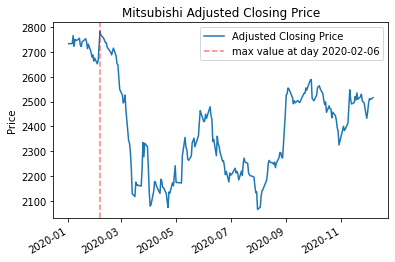

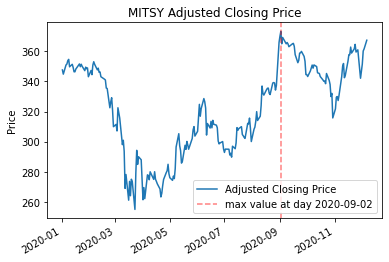

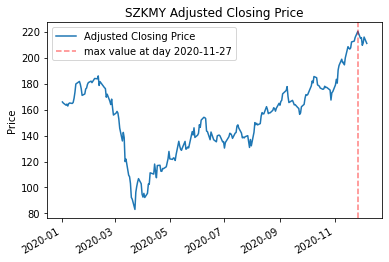

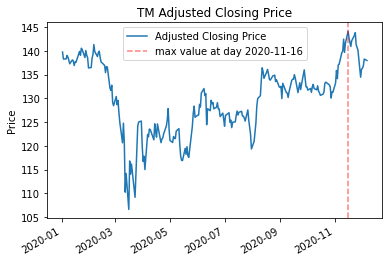

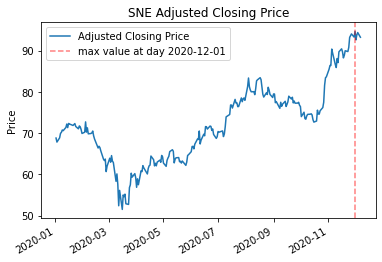

In [38]:
#for the plot:
date_index = datasets['close']['Date']
months = pd.to_datetime(date_index).dt.month
year = pd.to_datetime(date_index).dt.year
labels = (months.astype(str) + "-" + year.astype(str))
          
for name in highest_name:
    if name!='Date':
        stock_path = datasets['adj_close'][name]

        # find highest price
        stock_max_date = pd.to_datetime(date_index[stock_path.idxmax()])
        stock_max_date_name = str(stock_max_date)[:10]

        #plot time series
        fig, ax = plt.subplots()
        ax.plot(pd.to_datetime(date_index),stock_path, label='Adjusted Closing Price')
        # plot max
        plt.axvline( x=stock_max_date, color='red', linestyle='--', alpha=0.5, label='max value at day {}'.format(stock_max_date_name))
        title = name + ' Adjusted Closing Price'
        ax.xaxis_date()     
        fig.autofmt_xdate() 
        plt.title(title)
        plt.ylabel('Price')
        plt.legend()

### Plot difference difference open closing

In order to understand how much they loose each day

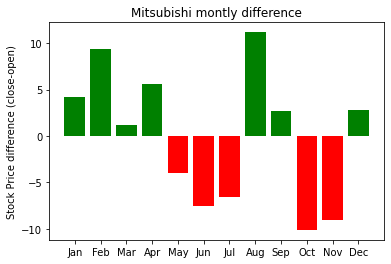

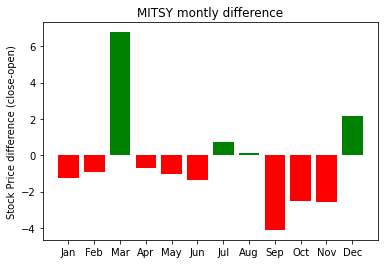

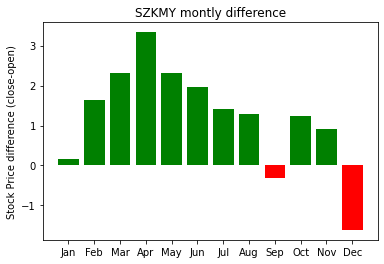

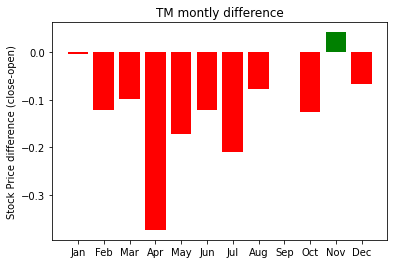

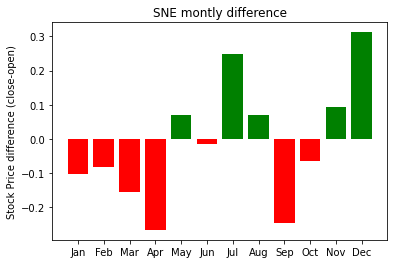

In [45]:
months_index = pd.to_datetime(date_index).dt.month
months_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
datasets['close']['month'] = months_index
df_lost_percentage = pd.DataFrame(index=index)

for name in highest_name:
    mean_close = datasets['close'][name]
    mean_open = datasets['open'][name]
    difference = mean_close - mean_open
    
    '''#plot daily scatter points
    colors = ['g' if x>0 else 'r' for x in difference]
    #fig, ax = plt.subplots()
    plt.scatter(date_index, difference, color=colors, linewidth=0.2)
    title = name + ' daily difference'
    plt.ylabel('Stock Price difference (close-open)')
    plt.title(title)
    #ax.xaxis_date()     
    #fig.autofmt_xdate() 
    plt.show()'''
    
    # bars:
    diff = pd.DataFrame(index=date_index)
    diff['month'] = months_index.values
    diff['diff'] = difference.values
    means_diff = diff.groupby('month').mean()['diff'].values
    
    #plot histograms
    colors = ['g' if x>0 else 'r' for x in means_diff]
    plt.bar(months_name, means_diff, color=colors)
    title = name + ' montly difference'
    plt.ylabel('Stock Price difference (close-open)')
    plt.title(title)
    plt.show()
    

### Return:

$R_t = \frac{S_t-S_{t-1}}{S_{t-1}}$

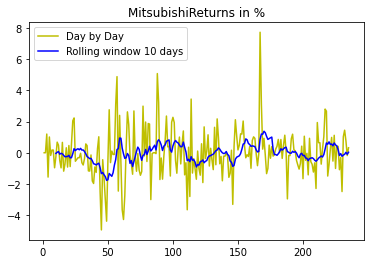

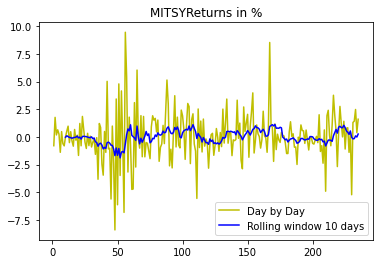

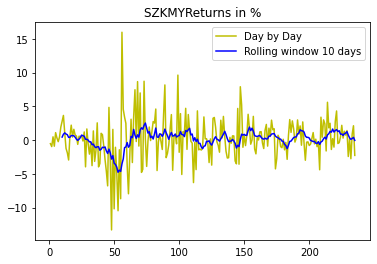

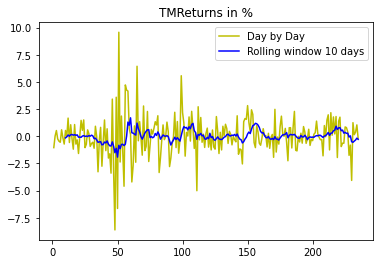

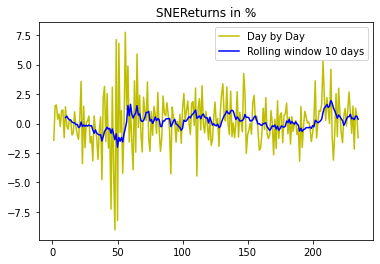

In [46]:
df_lost_percentage.head()
returns = pd.DataFrame()

for name in highest_name:
    
    returns[name] = (datasets['adj_close'][name] - datasets['adj_close'][name].shift(1))/datasets['adj_close'][name].shift(1)*100
    
    #plot time series
    plt.plot(returns[name].index, returns[name].values, color='y', label='Day by Day')
    
    # plot rolling windows
    rollingg = returns[name].rolling(10).mean()
    plt.plot(returns[name].index, rollingg, color='b', label='Rolling window 10 days')
    
    title = name + 'Returns in %'
    plt.title(title)
    plt.legend()
    plt.show()

In [47]:
returns['Date'] = index
returns = returns.set_index('Date')
returns.head()

,Mitsubishi,MITSY,SZKMY,TM,SNE
Date,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.000000,-0.796055,-0.521729,-1.047525,-1.419052
2020-01-06,0.000000,1.763106,-0.956556,0.014212,1.512923
2020-01-07,1.196250,0.174922,0.490420,0.525674,1.577196
2020-01-08,-1.559015,0.637486,-0.898203,-0.247327,0.370376


## SP500

In [48]:
# Download all SP500 data

def get_sp500_stocks_data(start, end):
    # current sp500 components (tickers list)
    sp_assets = pd.read_html(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    assets = sp_assets.Symbol.tolist()
    # Download historical data to a multi-index DataFrame
    try:
        data = yf.download(assets, start=start, end=end, as_panel=False)
        filename = 'sp_components_data.pkl'
        data.to_pickle(filename)
        print('Data saved at {}'.format(filename))
    except ValueError:
        print('Failed download, try again.')
        data = None
    return data


In [49]:
'''df_sp500_stocks = get_sp500_stocks_data(start, None)
df_sp500_stocks.to_csv('datasets_stocks/sp500_stocks.csv')'''

"df_sp500_stocks = get_sp500_stocks_data(start, None)\ndf_sp500_stocks.to_csv('datasets_stocks/sp500_stocks.csv')"

In [50]:
df_sp500_stocks = pd.read_csv('datasets_stocks/sp500_stocks.csv')
index_sp500 = df_sp500_stocks["Unnamed: 0"]

# only Adj Close prices, no volume
columns_adj_prices = [col for col in df_sp500_stocks if col.startswith('Adj Close')]
df_sp500_stocks = df_sp500_stocks[columns_adj_prices]

df_sp500_stocks.head()

,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Adj Close.5,Adj Close.6,Adj Close.7,Adj Close.8,Adj Close.9,...,Adj Close.495,Adj Close.496,Adj Close.497,Adj Close.498,Adj Close.499,Adj Close.500,Adj Close.501,Adj Close.502,Adj Close.503,Adj Close.504
0,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84.76229858398438,28.574403762817383,158.89895629882812,72.19286346435547,83.89559936523438,83.53189849853516,170.58999633789062,85.51184844970703,207.2430877685547,329.80999755859375,...,96.29391479492188,64.61932373046875,56.16490936279297,35.31545639038086,77.76145935058594,98.8283462524414,148.73587036132812,255.44000244140625,50.02912139892578,131.59608459472656
3,85.398193359375,28.982892990112305,158.1548309326172,73.84004211425781,84.85260772705078,83.59085845947266,168.80999755859375,85.60044860839844,206.8297119140625,334.42999267578125,...,100.11534881591797,65.656494140625,56.50235366821289,35.372928619384766,78.80762481689453,100.24114990234375,148.25889587402344,259.1400146484375,50.530181884765625,133.3759002685547
4,84.02704620361328,27.548194885253906,158.1647491455078,73.12215423583984,84.04720306396484,82.53959655761719,166.82000732421875,84.5569076538086,206.4852294921875,331.80999755859375,...,97.81067657470703,65.12865447998047,55.8770866394043,34.91316604614258,79.271484375,99.92719268798828,147.87135314941406,256.04998779296875,49.817134857177734,133.39578247070312


In [51]:
# correct columns names:

df_sp500_stocks = df_sp500_stocks.rename(columns=df_sp500_stocks.iloc[0]) # rename columns first line
df_sp500_stocks = df_sp500_stocks.drop(df_sp500_stocks.index[0]) # dlete first line
df_sp500_stocks = df_sp500_stocks.drop(df_sp500_stocks.index[0]) # delete data row'''
df_sp500_stocks['Date'] = index_sp500[2:] # we check this was fine !
df_sp500_stocks = df_sp500_stocks.set_index('Date')

df_sp500_stocks.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,84.76229858398438,28.574403762817383,158.89895629882812,72.19286346435547,83.89559936523438,83.53189849853516,170.58999633789062,85.51184844970703,207.2430877685547,329.80999755859375,...,96.29391479492188,64.61932373046875,56.16490936279297,35.31545639038086,77.76145935058594,98.8283462524414,148.73587036132812,255.44000244140625,50.02912139892578,131.59608459472656
2020-01-02,85.398193359375,28.982892990112305,158.1548309326172,73.84004211425781,84.85260772705078,83.59085845947266,168.80999755859375,85.60044860839844,206.8297119140625,334.42999267578125,...,100.11534881591797,65.656494140625,56.50235366821289,35.372928619384766,78.80762481689453,100.24114990234375,148.25889587402344,259.1400146484375,50.530181884765625,133.3759002685547
2020-01-03,84.02704620361328,27.548194885253906,158.1647491455078,73.12215423583984,84.04720306396484,82.53959655761719,166.82000732421875,84.5569076538086,206.4852294921875,331.80999755859375,...,97.81067657470703,65.12865447998047,55.8770866394043,34.91316604614258,79.271484375,99.92719268798828,147.87135314941406,256.04998779296875,49.817134857177734,133.39578247070312
2020-01-06,84.27545166015625,27.219409942626953,155.5653839111328,73.70481872558594,84.71047973632812,83.74805450439453,179.0399932861328,84.99991607666016,205.13690185546875,333.7099914550781,...,95.77192687988281,65.62871551513672,56.18476104736328,34.386356353759766,78.75828552246094,99.86833190917969,147.01678466796875,258.010009765625,49.210079193115234,132.3716583251953
2020-01-07,84.53377532958984,27.11977767944336,153.7200469970703,73.35818481445312,84.22723388671875,83.14872741699219,180.35000610351562,84.5273666381836,200.7079620361328,333.3900146484375,...,97.95840454101562,65.09160614013672,56.482505798339844,34.43424987792969,78.46219635009766,100.04493713378906,146.88760375976562,256.4700012207031,48.91136932373047,132.81907653808594


In [52]:
# values from string to float

for c in df_sp500_stocks.columns:
    try:
        df_sp500_stocks[c] = pd.to_numeric(df_sp500_stocks[c])
    except:
        pass
    
print(df_sp500_stocks.info())

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 2019-12-31 to 2020-12-07
Columns: 505 entries, A to ZTS
dtypes: float64(505)
memory usage: 936.9+ KB
None


In [53]:
# function to fill nan values of the sp500 stocks
def fill_nan_sp500 (dataset, index):
        
    # count nans:
    num_nans = dataset.isna().values.sum()
    print(f"Totally, in the dataset there are {num_nans} NaNs values")
    
    # check if all column null and delete it
    # this is possible only if num_nan>= len(index)
    if num_nans >= len(index):
        dataset_null_column = dataset.isnull().all()
        dataset_null_column = map(operator.not_, dataset_null_column)# we want ot keep true but previous function gives falses
        dataset = dataset.loc[:, dataset_null_column]

    if num_nans>0:
        if 'Date' in dataset.columns:
            dataset = dataset.drop('Date', axis=1) # drop date because the next line works only with floats
        dataset = (dataset.ffill() + dataset.bfill())/2
        dataset['Date'] = index.values # reintegrate the index
    
        num_nans = dataset.isna().values.sum()
        print(f"After the filling thought the mean, in the dataset there are {num_nans} NaNs values")

        if num_nans>0:
            # the still missing values are at the beginning or at the end. fill them with the first or last non NaN value
            dataset = dataset.ffill()
            dataset = dataset.bfill()
            print(f"After the filling of first/last values, in the dataset there are {dataset.isna().values.sum()} NaNs values")

    return dataset

In [54]:
# fill NaN
df_sp500_stocks = fill_nan_sp500(df_sp500_stocks, index_sp500[2:])

Totally, in the dataset there are 915 NaNs values
After the filling thought the mean, in the dataset there are 358 NaNs values
After the filling of first/last values, in the dataset there are 0 NaNs values


In [55]:
df_sp500_stocks.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,Date
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,84.762299,28.574404,158.898956,72.192863,83.895599,83.531898,170.589996,85.511848,207.243088,329.809998,...,64.619324,56.164909,35.315456,77.761459,98.828346,148.735870,255.440002,50.029121,131.596085,2019-12-31
2020-01-02,85.398193,28.982893,158.154831,73.840042,84.852608,83.590858,168.809998,85.600449,206.829712,334.429993,...,65.656494,56.502354,35.372929,78.807625,100.241150,148.258896,259.140015,50.530182,133.375900,2020-01-02
2020-01-03,84.027046,27.548195,158.164749,73.122154,84.047203,82.539597,166.820007,84.556908,206.485229,331.809998,...,65.128654,55.877087,34.913166,79.271484,99.927193,147.871353,256.049988,49.817135,133.395782,2020-01-03
2020-01-06,84.275452,27.219410,155.565384,73.704819,84.710480,83.748055,179.039993,84.999916,205.136902,333.709991,...,65.628716,56.184761,34.386356,78.758286,99.868332,147.016785,258.010010,49.210079,132.371658,2020-01-06
2020-01-07,84.533775,27.119778,153.720047,73.358185,84.227234,83.148727,180.350006,84.527367,200.707962,333.390015,...,65.091606,56.482506,34.434250,78.462196,100.044937,146.887604,256.470001,48.911369,132.819077,2020-01-07


In [56]:
df_sp500 = df_sp500_stocks.mean(axis=1)
df_sp500.head()

Date
2019-12-31    139.455022
2020-01-02    140.214432
2020-01-03    139.692840
2020-01-06    140.040980
2020-01-07    139.934118
dtype: float64

In [57]:
# sp500 lost in percentage:
returns_sp500 = (df_sp500 - df_sp500.shift(1))/df_sp500.shift(1)*100
returns_sp500.head()

Date
2019-12-31         NaN
2020-01-02    0.544555
2020-01-03   -0.371996
2020-01-06    0.249218
2020-01-07   -0.076308
dtype: float64

In [58]:
df_to_merge = pd.DataFrame(returns_sp500).iloc[1:,:].rename(columns = {0:'sp500'})
df_lost_sp500 = returns.merge( df_to_merge , left_index=True, right_index=True)
df_lost_sp500.head()

,Mitsubishi,MITSY,SZKMY,TM,SNE,sp500
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,0.544555
2020-01-03,0.000000,-0.796055,-0.521729,-1.047525,-1.419052,-0.371996
2020-01-06,0.000000,1.763106,-0.956556,0.014212,1.512923,0.249218
2020-01-07,1.196250,0.174922,0.490420,0.525674,1.577196,-0.076308
2020-01-08,-1.559015,0.637486,-0.898203,-0.247327,0.370376,0.342498


In [ ]:
for name in highest_name:
    
    y2 = returns[name]
    y1 = df_lost_sp500['sp500']
    plt.plot(index, y2, label=name, color='b', linewidth=1)
    plt.plot(index, y1, label='SP500', color='m', linewidth=1)
    #plt.fill_between(index, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
    #plt.fill_between(index, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
    plt.legend()
    title = 'Comparinson between losts ' + name + ' vs SP500'
    plt.title(title)
    plt.ylabel('Returns in %')
    plt.show()

In this way it is really hard to enderstand. Therefore, let us work with rolling windows

### Rolling Windows:

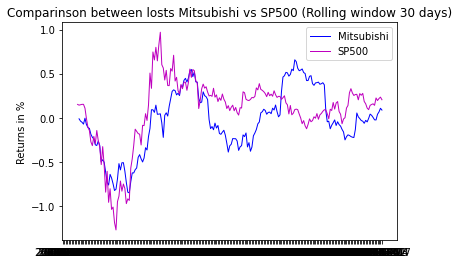

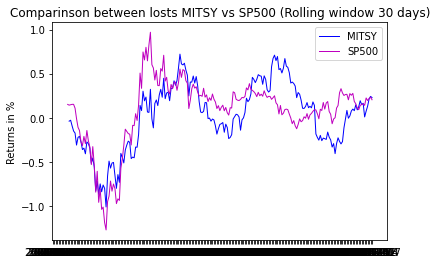

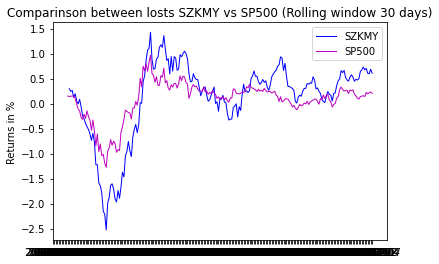

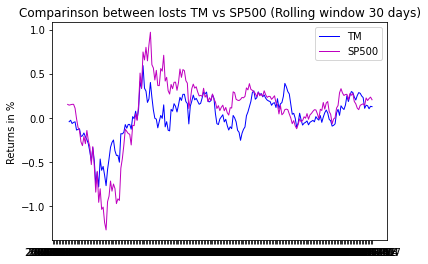

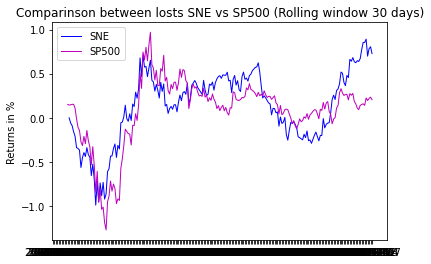

In [60]:
for name in highest_name:
    
    y2 = returns[name].rolling(30).mean()
    y1 = df_lost_sp500['sp500'].rolling(30).mean()
    plt.plot(index, y2, label=name, color='b', linewidth=1)
    plt.plot(index, y1, label='SP500', color='m', linewidth=1)
    #plt.fill_between(index, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
    #plt.fill_between(index, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
    plt.legend()
    title = 'Comparinson between losts ' + name + ' vs SP500 (Rolling window 30 days)'
    plt.title(title)
    plt.ylabel('Returns in %')
    plt.show()

## Variance

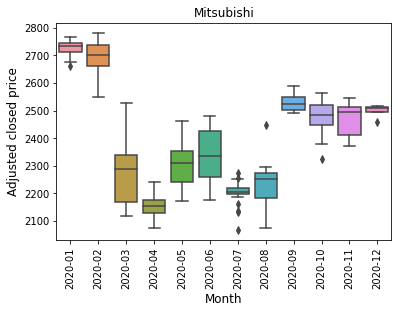

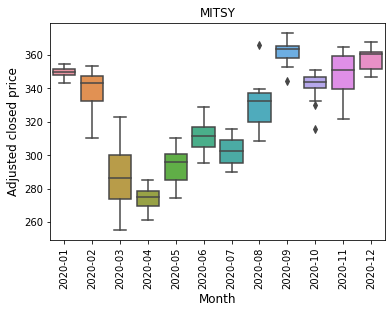

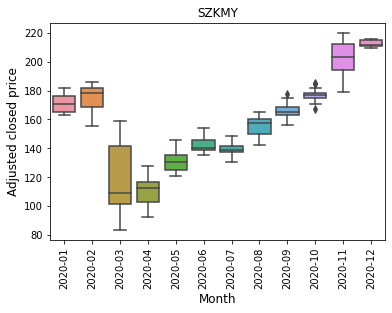

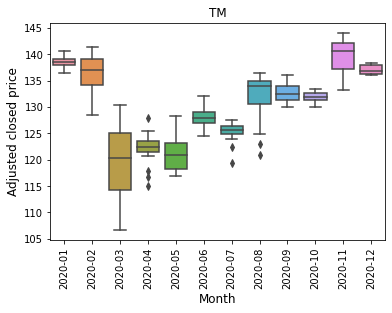

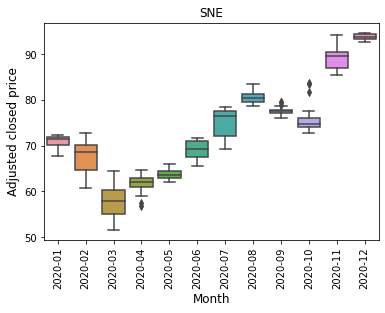

In [62]:
for name in highest_name:
    df = datasets['adj_close'][['Date', name]]
    df['Month'] = pd.to_datetime(df['Date']).dt.to_period("M")
    plt.figure()
    sns.boxplot(data=df, x="Month", y=name)
    plt.xticks(rotation=90)
    plt.xlabel("Month", size=12)
    plt.ylabel("Adjusted closed price", size=12)
    title = 'Variance of ' +  name
    plt.title(title)
    plt.show()

## Create portfolios with adjusted closed price
### EW

In [67]:
df_portfolio = pd.DataFrame(index=date_index)

In [64]:
adj_close = datasets['adj_close'].set_index('Date')
adj_close.head()

,TM,Mitsubishi,HMC,1JP.F,NPEXY,ITOCY,NSANY,SFTBY,HTHIY,JXHLY,...,NHOLF,SSUMY,MZDAY,KAEPY,MAHLY,SMTOF,FUJHY,CHUEF,EJPRY,NEC1.F
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,139.752579,2733.517578,28.217022,-20.443104,12.14196,45.664928,11.64,21.863840,84.063606,8.930202,...,39.234413,14.467053,4.112554,5.720822,22.264050,2.510621,12.291511,14.7,14.937948,-1.582518
2020-01-03,138.288635,2733.517578,27.714552,-20.687929,12.14196,45.400230,11.56,21.555620,83.049728,8.745774,...,39.234413,14.243286,4.073847,5.720822,22.264050,2.510621,12.192784,14.7,14.789459,-1.556855
2020-01-06,138.308289,2733.517578,27.635735,-20.443104,12.14196,45.674728,11.56,21.038603,84.280167,9.192285,...,39.234413,14.505970,4.073847,5.720822,21.710169,2.496441,12.173038,14.7,14.730064,-1.608180
2020-01-07,139.035339,2766.217285,27.793371,-20.810345,12.14196,45.772762,11.66,21.147972,83.906105,9.192285,...,39.234413,14.447596,4.093201,5.720822,21.710169,2.496441,12.064439,14.7,14.769661,-1.659505
2020-01-08,138.691467,2723.091553,27.714552,-20.565516,12.14196,45.949226,11.68,21.257339,83.650177,9.337885,...,39.234413,14.389221,4.073847,5.720822,21.710169,2.496441,12.094057,14.7,14.819158,-1.702276


In [70]:
df_portfolio['EW'] = adj_close.mean(axis=1).values
df_portfolio.head()

,EW
Date,
2020-01-02,88.785293
2020-01-03,88.538377
2020-01-06,88.687530
2020-01-07,89.406308
2020-01-08,88.574525


### VW
The first 5 have 60% of the value and all the others 40%

In [93]:
# names two groups
stocks_60_names =  highest_name
stocks_40_names = [ stock for stock in adj_close.columns if stock not in  highest_name]  

# stocks value two groups
stocks_60 = adj_close[stocks_60_names]
stocks_40 = adj_close[stocks_40_names]

# mean each group
stocks_60_mean = stocks_60.mean(axis=1).values
stocks_40_mean = stocks_40.mean(axis=1).values

# weight 60 40:
df_portfolio['VW'] = stocks_60_mean * 0.6 + stocks_40_mean * 0.4

Of course the VW portfolio has higher values

In [96]:
df_portfolio.head()

,EW,VW
Date,,
2020-01-02,88.785293,423.409333
2020-01-03,88.538377,422.624831
2020-01-06,88.687530,423.307588
2020-01-07,89.406308,427.619028
2020-01-08,88.574525,422.533327


In [97]:
# save:
df_portfolio.to_csv('datasets_stocks/japan_portfolio.csv')